Trabalho  - Usando LSTM para prever séries temporais

Nesse laboratório iremos demonstrar como uma LSTM pode ser usada para previsão em séries temporais. Utilizaremos uma rede neuronal LSTM bem simples para tratar um caso de uma série temporal de número de doenças pulmonares na inglaterra

In [1]:
# Importando bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Conv1D, Dropout
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from google.colab import files
np.random.seed(7)

In [2]:
# Carrega apenas a coluna com o total de doentes por mês 
dataframe = pd.read_excel('Geracao_Eolica_ONS_Mensal_2.xlsx', sheet_name='Mensal')
dataframe.head(100)

,Geracao
0,2314
1,2766
2,2761
3,3274
4,3907
5,4076
6,4314
7,4139
8,4098
9,3573


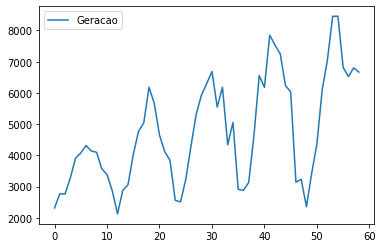

In [3]:
dataframe.plot()

In [4]:
#Converte a coluna do dataframe pandas em um vetor numpy

dataset = dataframe.values
dataset = dataset.astype('float32')

look_back = 1

# Divite os dados de treino (2/3) e teste (1/3)
# Note que a divisão não é aleatória, mas sim sequencial
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size-look_back-1:len(dataset),:]


In [5]:
# Recebe uma série e converte em uma matriz com séries deslocadas.
def create_dataset(dataset, look_back=12, std=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]-dataset[i, 0]
        a /= std
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0]-dataset[i + look_back-12, 0])
    return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
std = train[:, 0].std()
trainX, trainY = create_dataset(train, look_back, std)
testX, testY = create_dataset(test, look_back, std)
# shape is [samples, time steps, features]

trainX = trainX.reshape(-1, look_back, 1)
testX = testX.reshape(-1, look_back, 1)
trainY = trainY / 30
testY = testY / 30

trainX.shape, testX.shape

((40, 1, 1), (19, 1, 1))

In [6]:
model = Sequential()
model.add(LSTM(128, input_shape=(look_back, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(8, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='sgd')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dropout_1 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 32)             12416     
                                                                 
 dropout_2 (Dropout)         (None, 1, 32)             0         
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             3

In [7]:
callbacks = [
    ReduceLROnPlateau(patience=10, factor=0.5, verbose=True),
    ModelCheckpoint('best.model', save_best_only=True),
    EarlyStopping(patience=25, verbose=True)
]

history = model.fit(trainX, trainY, epochs=5000, batch_size=24, validation_data=(testX, testY),
                    verbose=0, callbacks=callbacks)

INFO:tensorflow:Assets written to: best.model/assets


INFO:tensorflow:Assets written to: best.model/assets



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 26: early stopping


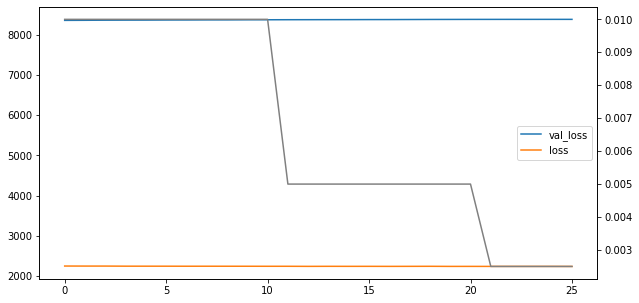

In [8]:
df_history = pd.DataFrame(history.history)
ax = df_history[['val_loss', 'loss']].plot(figsize=(10, 5))
df_history['lr'].plot(ax=ax.twinx(), color='gray')

In [9]:
# Realiza as previsões. Serve apenas para exibir no gráfico.

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Ao final das previsões, reescalonamos os dados para a escala original e calculamos as métricas de RMSE.

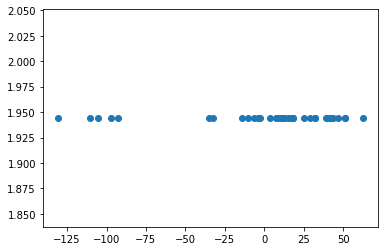

In [10]:
plt.scatter(trainY, trainPredict.ravel())

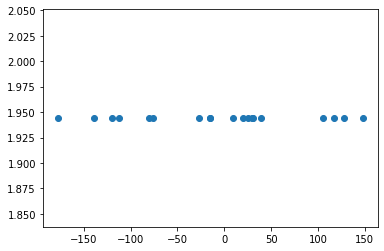

In [11]:
plt.scatter(testY, testPredict.ravel())

In [12]:
# Calcula os erros de previsão - RMSE
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 47.33 RMSE
Test Score: 91.55 RMSE


In [13]:
# Calcula os erros de previsão - MAPE
Train_MAPE = mean_absolute_percentage_error(trainY, trainPredict[:,0])
print(' Train Score: %.2f MAPE' % (Train_MAPE))

Test_MAPE = mean_absolute_percentage_error(testY, testPredict[:,0])
print(' Test Score: %.2f MAPE' % (Test_MAPE))

 Train Score: 0.97 MAPE
 Test Score: 0.99 MAPE


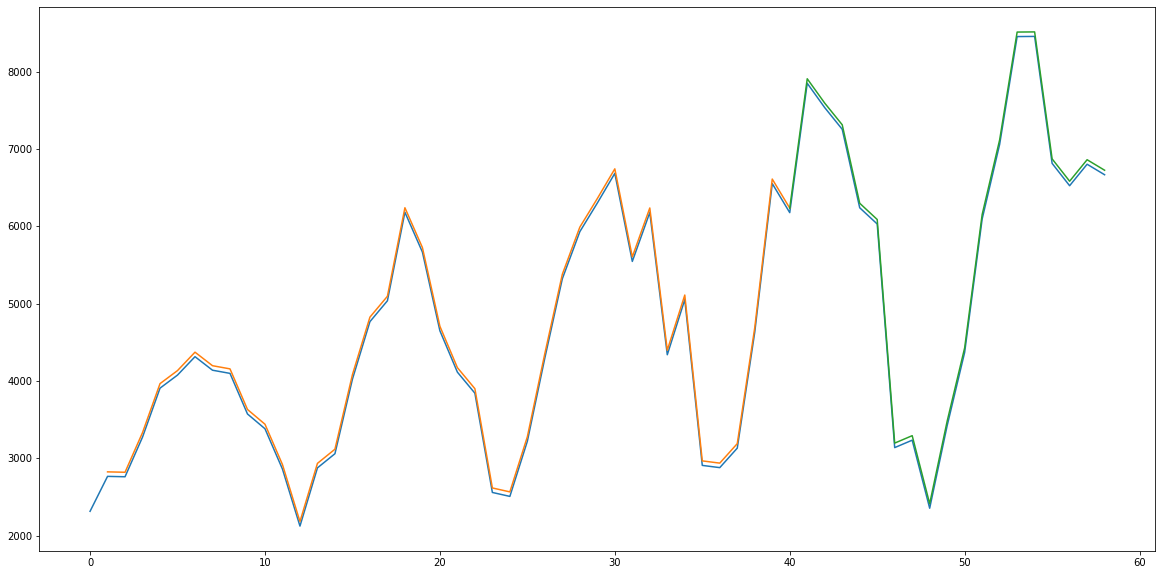

In [14]:
# shift train predictions for plotting
trainPredictPlot = (trainPredict.ravel() * 30) + dataset[look_back:len(trainPredict)+look_back, 0]

# shift test predictions for plotting
testPredictPlot = (testPredict.ravel() * 30) + dataset[len(trainPredict)+(look_back)-1:len(dataset), 0]

# plot baseline and predictions
plt.figure(figsize=(20, 10))
plt.plot(dataset)
plt.plot(look_back+np.arange(len(trainPredictPlot)), trainPredictPlot)
plt.plot(look_back+np.arange(len(testPredictPlot))+len(trainPredictPlot)-1, testPredictPlot)
plt.show()